In [1]:
import os, sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import torch
import torch.nn as nn 
import torchvision
import gc
import random
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from tqdm import tqdm_notebook as tqdm

from src import distributions
from src.resnet2 import ResNet_D
from src.unet import CondUNetV2, UNet
from src.mnistm_utils import MNISTM
from src.tools import weights_init_D
from src.plotters import plot_images
from src.guided_samplers import Sampler, PairedSubsetSampler, SubsetGuidedDataset, get_indicies_subset
from src.tools import fig2data, fig2img, freeze, unfreeze

## Init Parameters

In [2]:
NUM_LABELED = 10
DATASET = 'fmnist2mnist'
COST = 'Weak_Energy'
DATASET_PATH = '../datasets/'

BATCH_SIZE = 16
C_SIZE = 2
Z_SIZE = 2
IMG_SIZE = 32
T_ITERS = 10
D_LR = 1e-5 
T_LR = 1e-5
NC = 1
ZD = 128
Z_STD = 1.
PLOT_INTERVAL = 500
CPKT_INTERVAL = 10000
MAX_STEPS = 2501 #For illustration purpose only. For training use 60001
SEED = 0x000001
source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9])
new_labels_source = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
scheduler_milestones=[10000, 20000, 30000, 40000, 50000]

source_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)), 
    ToTensor(),
    Normalize((0.5), (0.5)),
])
target_transform = source_transform

if DATASET == 'mnist2kmnist':
    source = datasets.MNIST
    target = datasets.KMNIST
    
elif DATASET == 'fmnist2mnist':
    source = datasets.FashionMNIST
    target = datasets.MNIST
    
elif DATASET == 'mnist2usps':
    source = datasets.MNIST
    target = datasets.USPS
    
elif DATASET == 'mnist2mnistm':
    source = datasets.MNIST
    target = MNISTM
    NC = 3
    source_transform = Compose([
        Resize((IMG_SIZE, IMG_SIZE)), 
        ToTensor(),
        Normalize((0.5), (0.5)), 
        Lambda(lambda x: -x.repeat(3,1,1))])
    target_transform = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
OUTPUT_PATH = '../saved_models/{}/'.format(DATASET)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
torch.manual_seed(SEED); np.random.seed(SEED)

## Upload ClassGuided Datasets

In [3]:
source_train = source(root=DATASET_PATH, train=True, download=True, transform=source_transform)
subset_samples, labels, source_class_indicies = get_indicies_subset(source_train, 
                                                                    new_labels = new_labels_source, 
                                                                    classes=len(source_subset), 
                                                                    subset_classes=source_subset)
source_train =  torch.utils.data.TensorDataset(torch.stack(subset_samples), 
                                               torch.LongTensor(labels))


target_train = target(root=DATASET_PATH, train=True, download=True, transform=target_transform)   
target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_train, 
                                                                                  new_labels = new_labels_target, 
                                                                                  classes=len(target_subset), 
                                                                                  subset_classes=target_subset)
target_train = torch.utils.data.TensorDataset(torch.stack(target_subset_samples), 
                                              torch.LongTensor(target_labels))

train_set = SubsetGuidedDataset(source_train, target_train, 
                                num_labeled=NUM_LABELED, 
                                in_indicies = source_class_indicies, 
                                out_indicies = target_class_indicies)

full_set = SubsetGuidedDataset(source_train, target_train, 
                               num_labeled='all', 
                               in_indicies = source_class_indicies, 
                               out_indicies = target_class_indicies)

T_XY_sampler = PairedSubsetSampler(train_set, subsetsize=C_SIZE)
D_XY_sampler = PairedSubsetSampler(full_set, subsetsize=1)
X_fixed, Y_fixed = D_XY_sampler.sample(10)

## Init Networks

In [4]:
D = ResNet_D(IMG_SIZE, nc=NC).cuda()
D.apply(weights_init_D)
T = CondUNetV2(NC, NC, ZD, base_factor=48).cuda()

T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)
T_scheduler = torch.optim.lr_scheduler.MultiStepLR(T_opt, milestones=scheduler_milestones, gamma=0.5)
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=scheduler_milestones, gamma=0.5)

## Start Training

In [5]:
def train(T, D, T_opt, D_opt, T_XY_sampler, D_XY_sampler, T_scheduler, D_scheduler, batch_size = 64, plot_interval=1000, max_steps=100001):
    for step in tqdm(range(max_steps)):
        unfreeze(T); freeze(D)
        for t_iter in range(T_ITERS): 
            T_opt.zero_grad()
            X, Y = T_XY_sampler.sample(batch_size)
            X = X[:,:,None].repeat(1, 1, Z_SIZE, 1, 1, 1)
            Y = Y[:,:,None].repeat(1, 1, Z_SIZE, 1, 1, 1)
            Z = torch.randn(batch_size, C_SIZE, Z_SIZE, ZD, 1, 1, device='cuda') * Z_STD
            T_X = T(X.flatten(start_dim=0, end_dim=2), Z.flatten(start_dim=0, end_dim=2)).permute(1,2,3,0).reshape(NC, IMG_SIZE, IMG_SIZE, -1, C_SIZE, Z_SIZE).permute(3,4,5,0,1,2)

            T_var = .5 * torch.cdist(T_X.flatten(start_dim=0, end_dim=1).flatten(start_dim=2), 
                                     T_X.flatten(start_dim=0, end_dim=1).flatten(start_dim=2)).mean() * C_SIZE / (C_SIZE-1) 
            cost = (Y.flatten(start_dim=1, end_dim=2) - T_X.flatten(start_dim=1, end_dim=2)).flatten(start_dim=2).norm(dim=2).mean() 
            T_loss = cost - T_var - D(T_X.flatten(start_dim=0, end_dim=2)).mean()
            T_loss.backward(); T_opt.step()
                
        T_scheduler.step()
        del T_loss, T_X, X, Y; gc.collect(); torch.cuda.empty_cache() 

        freeze(T); unfreeze(D)
        X, _ = T_XY_sampler.sample(batch_size)
        _, Y = D_XY_sampler.sample(batch_size)
        with torch.no_grad():
            X = X[:,:,None].repeat(1, 1, Z_SIZE, 1, 1, 1) 
            Y = Y[:,:,None].repeat(1, 1, Z_SIZE, 1, 1, 1) 
            Z = torch.randn(batch_size, C_SIZE, Z_SIZE, ZD, 1, 1, device='cuda') * Z_STD
            XZ = (X.flatten(start_dim=0, end_dim=2), Z.flatten(start_dim=0, end_dim=2))
            T_X = T(*XZ)
        D_opt.zero_grad()
        D_loss = D(T_X).mean() - D(Y.flatten(start_dim=0, end_dim=2)).mean()
        D_loss.backward(); D_opt.step();
        D_scheduler.step()

        del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
        if step % plot_interval == 0:
            Z = torch.randn(10, 1, 1, ZD, 1, 1, device='cuda') * Z_STD 
            Z = Z.flatten(start_dim=0, end_dim=2)
            
            print('X_fixed results')
            fig, axes = plot_images(X_fixed[:,:,None].flatten(start_dim=0, end_dim=2), Y_fixed[:,:,None].flatten(start_dim=0, end_dim=2), T, Z=Z) 
            plt.show()
            plt.close(fig) 
            
            print('X_random results')
            X_random, Y_random = D_XY_sampler.sample(10)
            fig, axes = plot_images(X_random[:,:,None].flatten(start_dim=0, end_dim=2), Y_random[:,:,None].flatten(start_dim=0, end_dim=2), T, Z=Z)
            plt.show()
            plt.close(fig) 

        if step % CPKT_INTERVAL == 0:
            freeze(T); 
            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'T_{step}.pt'))
            torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'D_{step}.pt'))
            torch.save(D_opt.state_dict(), os.path.join(OUTPUT_PATH, f'D_opt_{step}.pt'))
            torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{step}.pt'))

        gc.collect(); torch.cuda.empty_cache()

  0%|          | 0/2501 [00:00<?, ?it/s]

X_fixed results


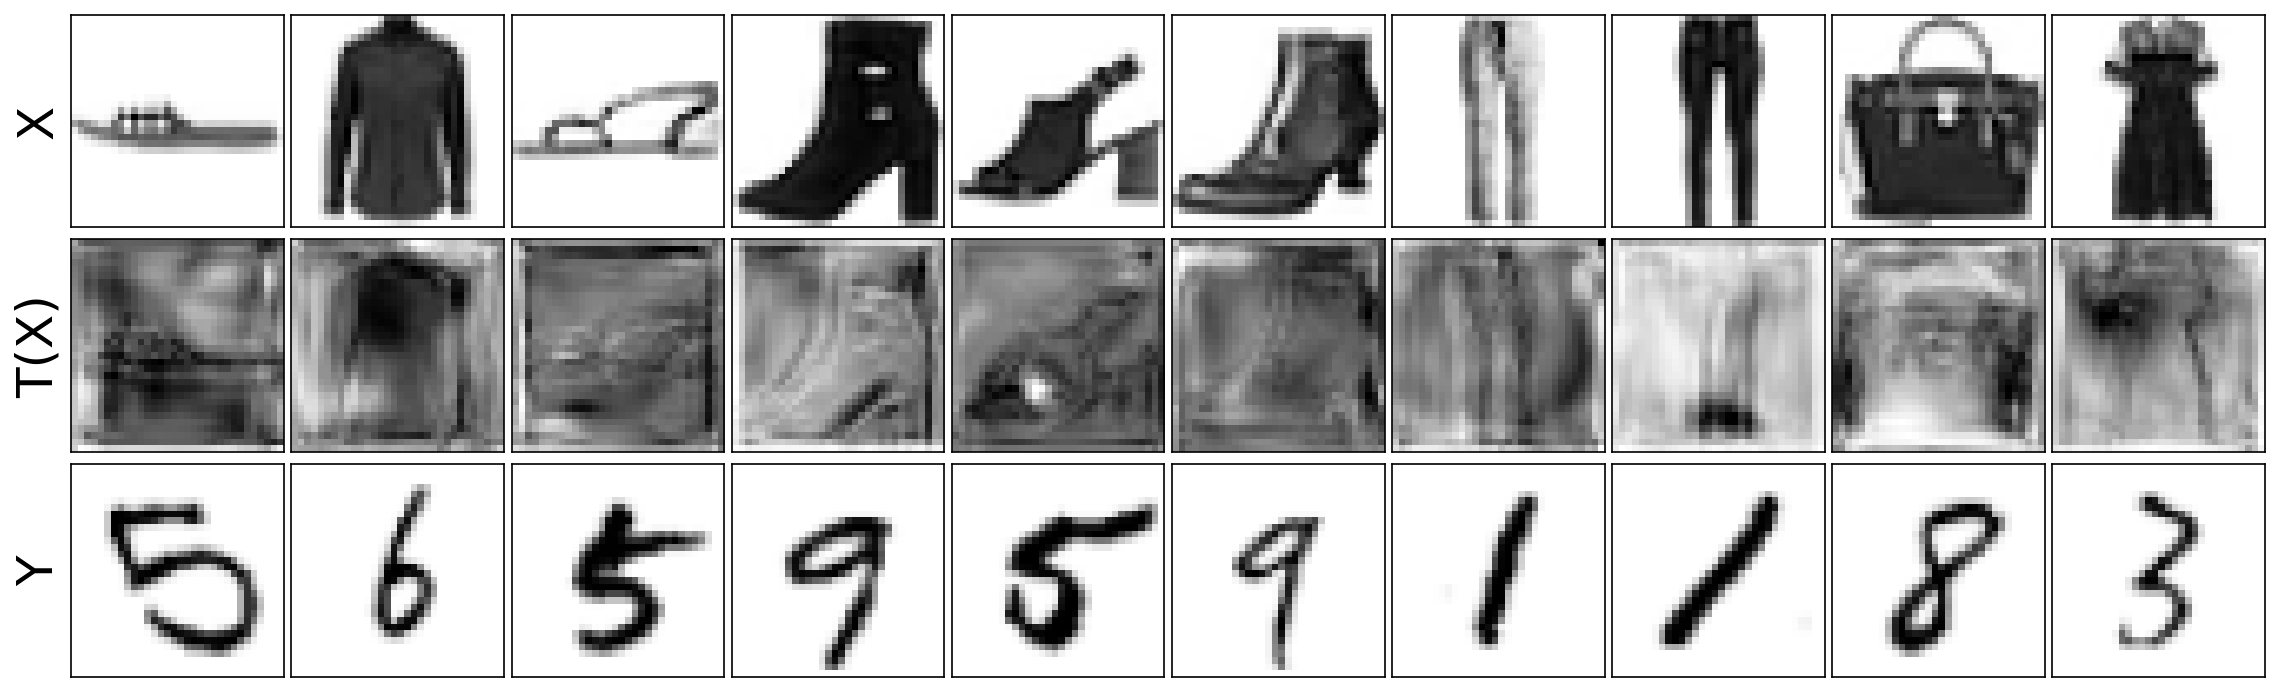

X_random results


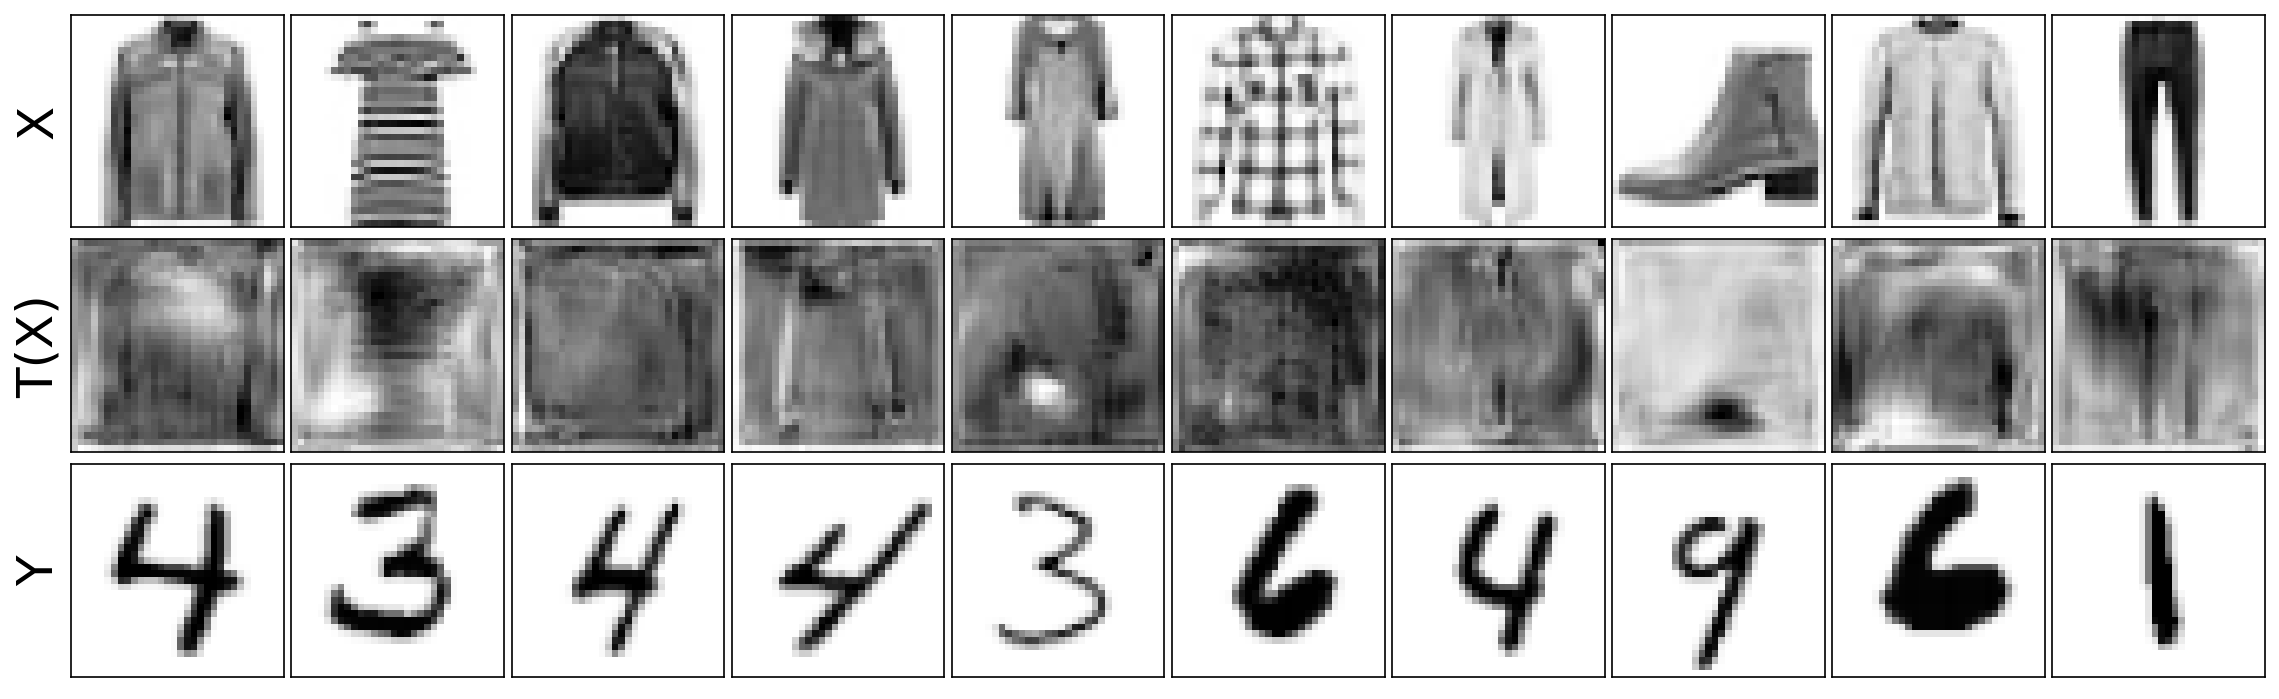

X_fixed results


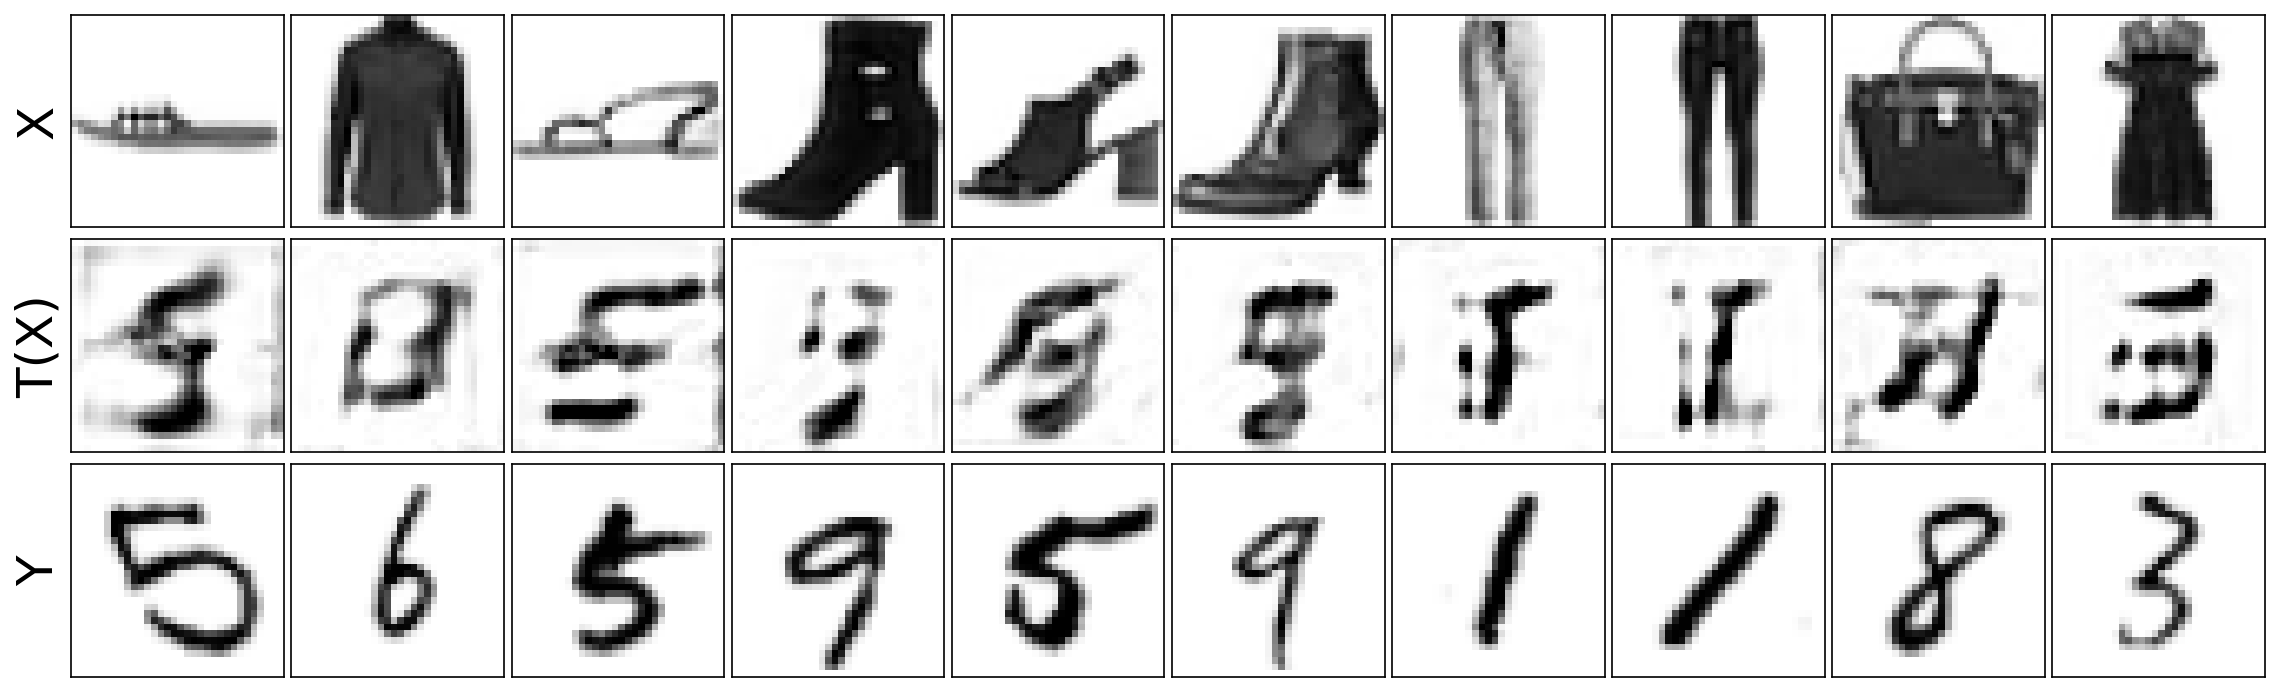

X_random results


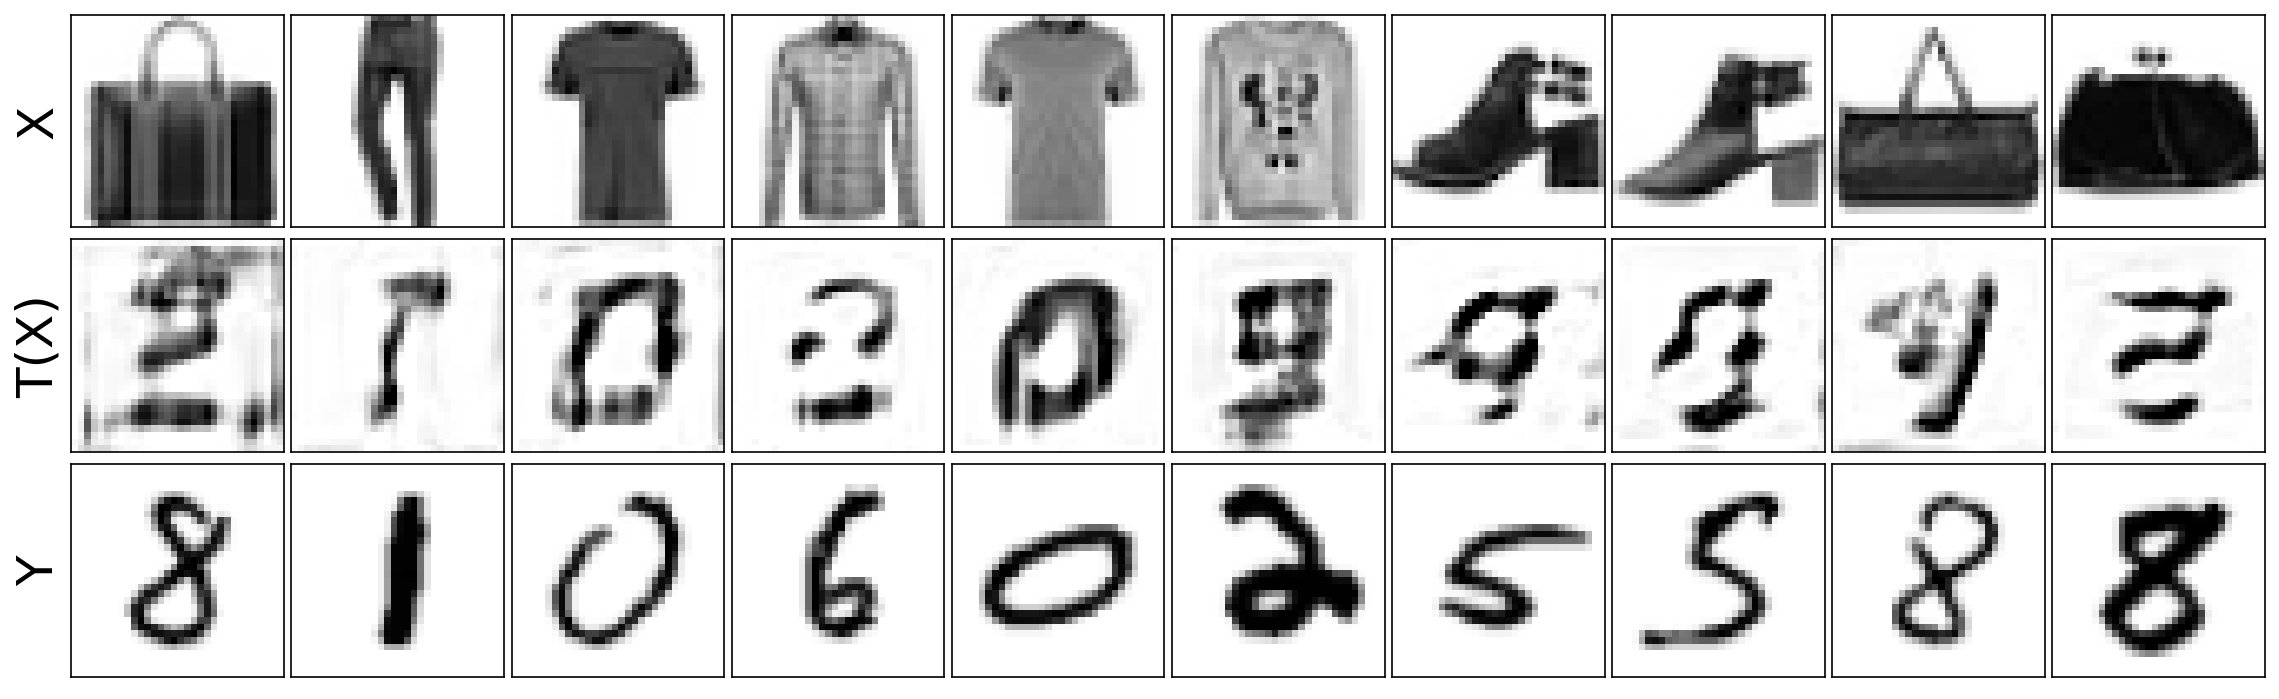

X_fixed results


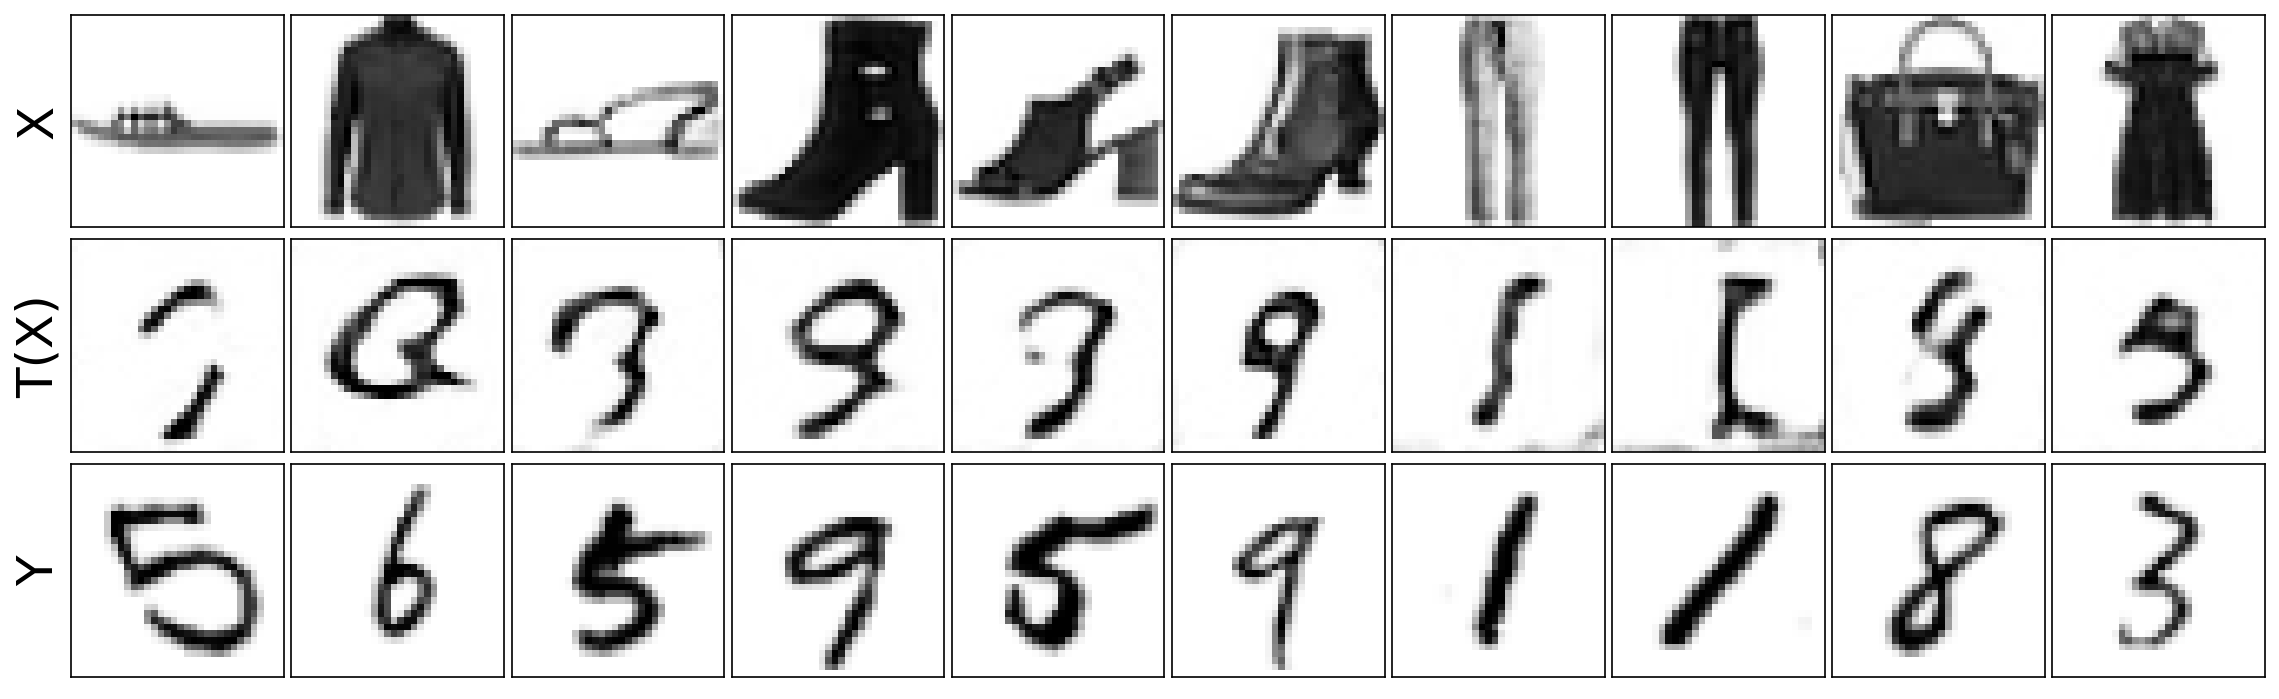

X_random results


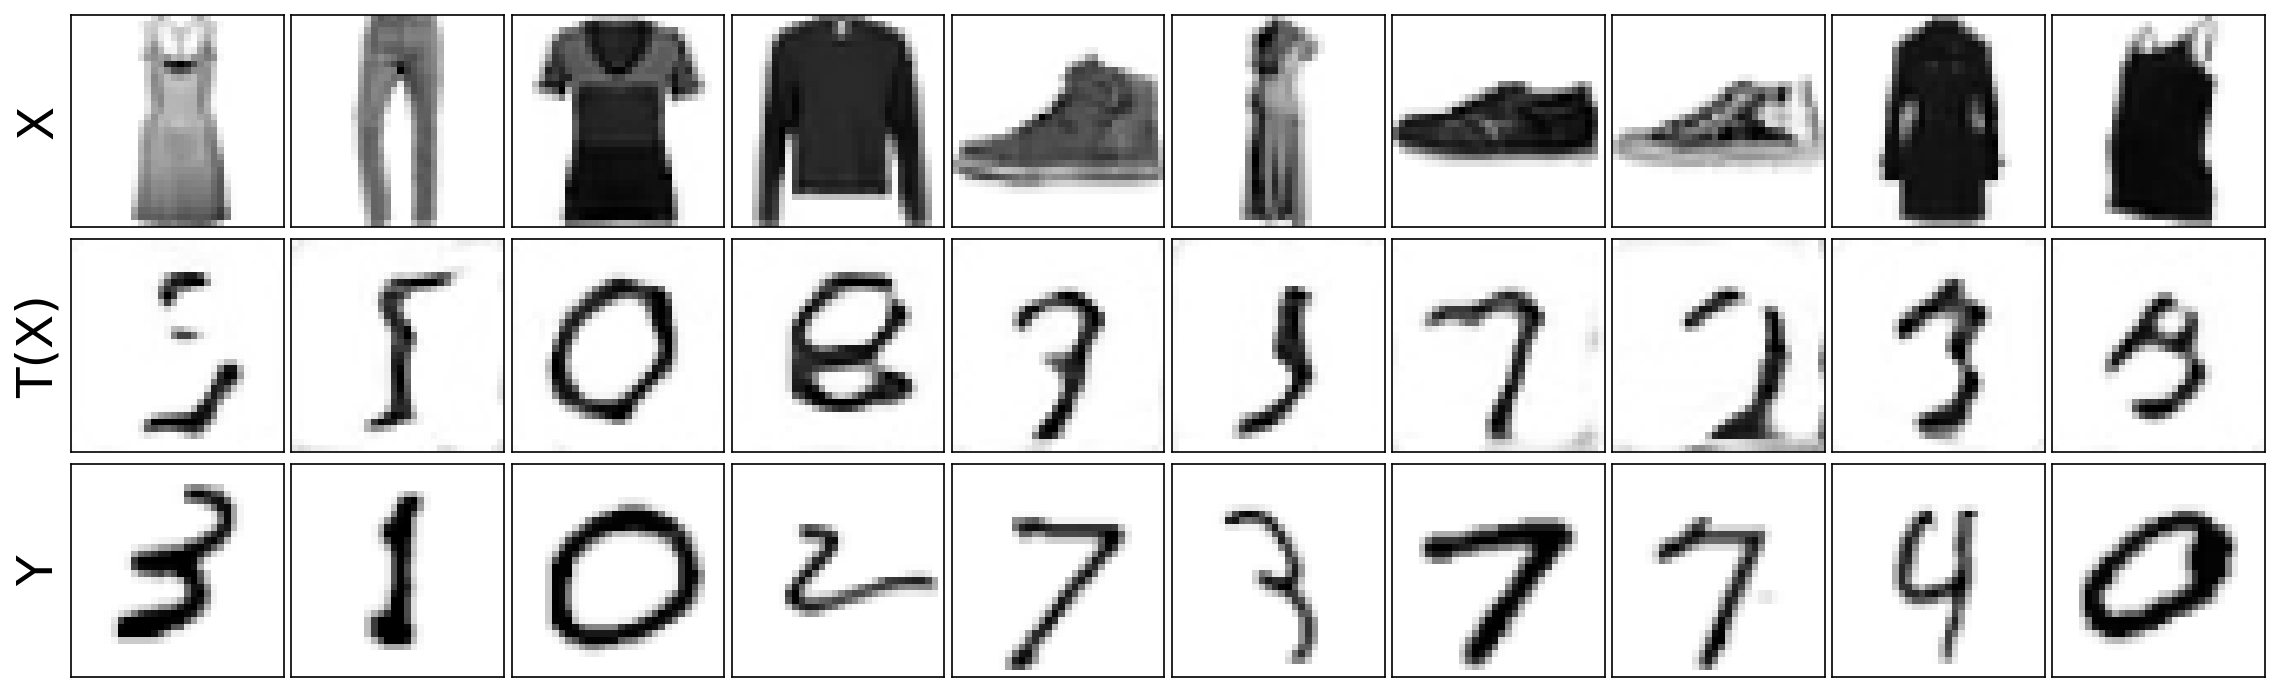

X_fixed results


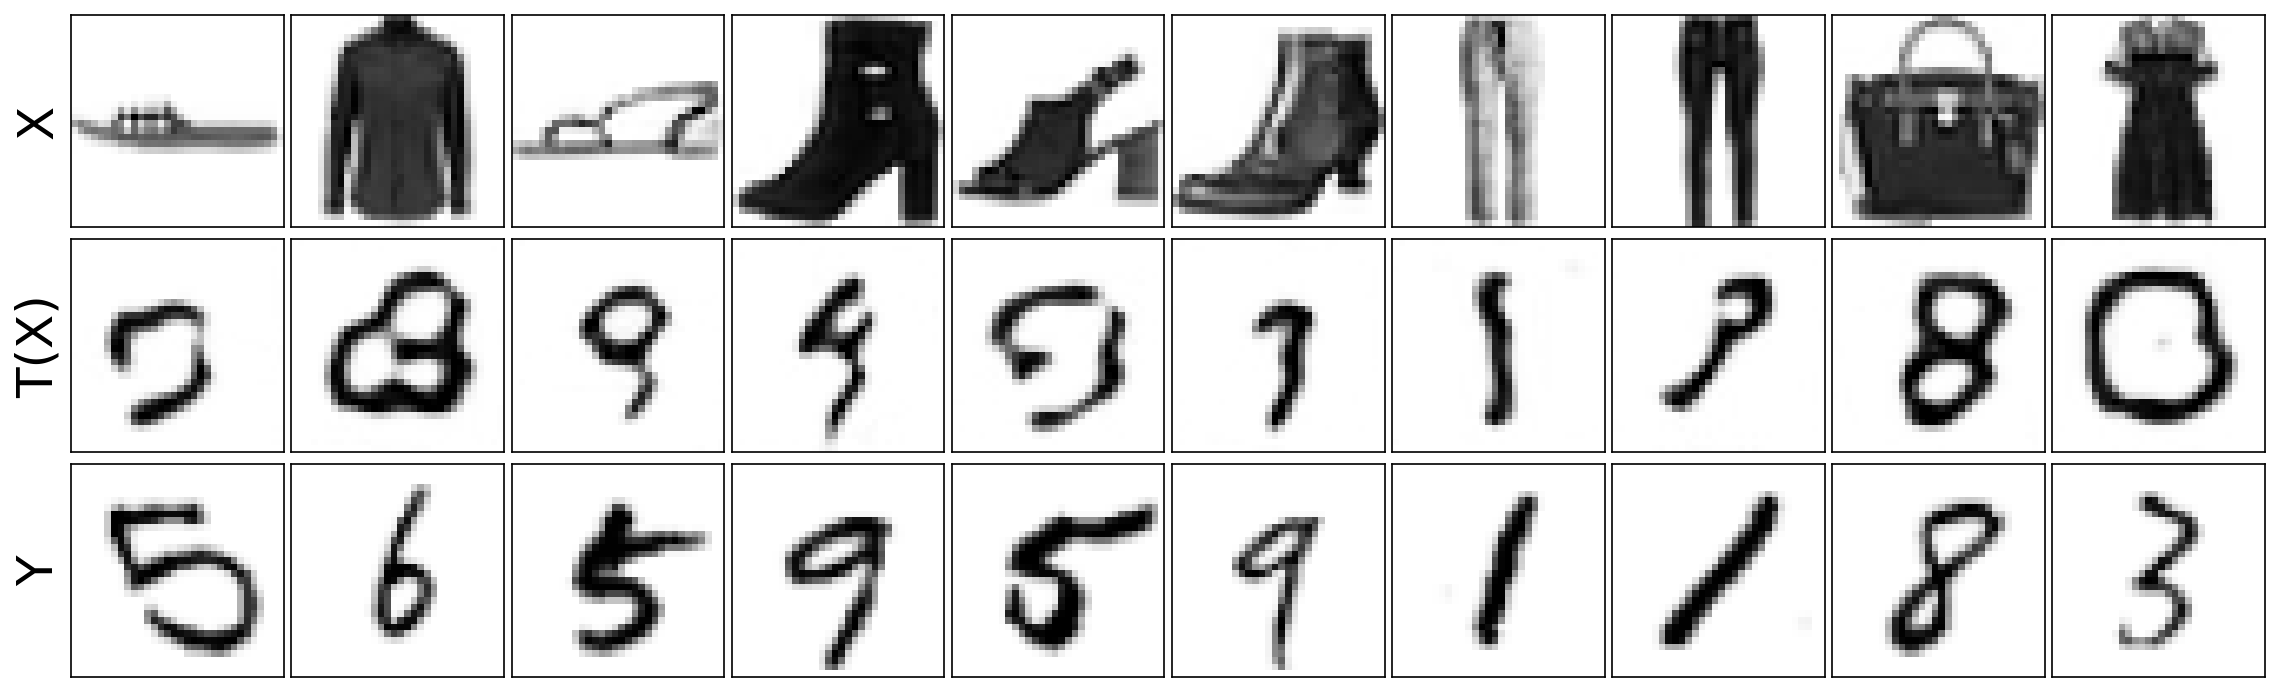

X_random results


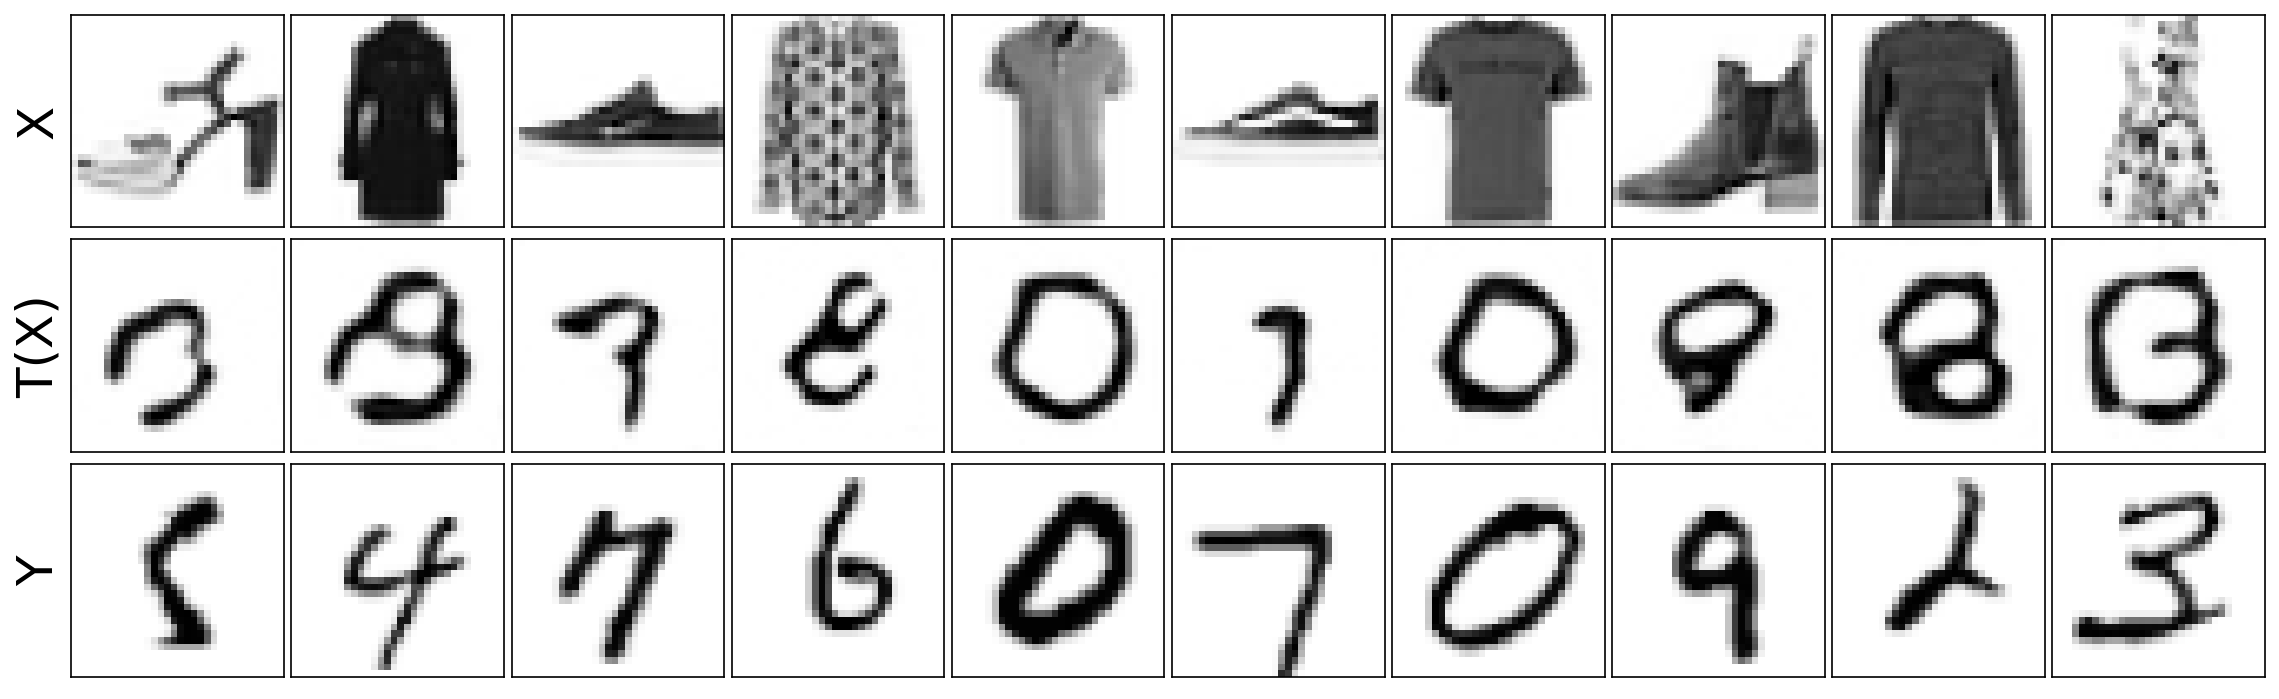

X_fixed results


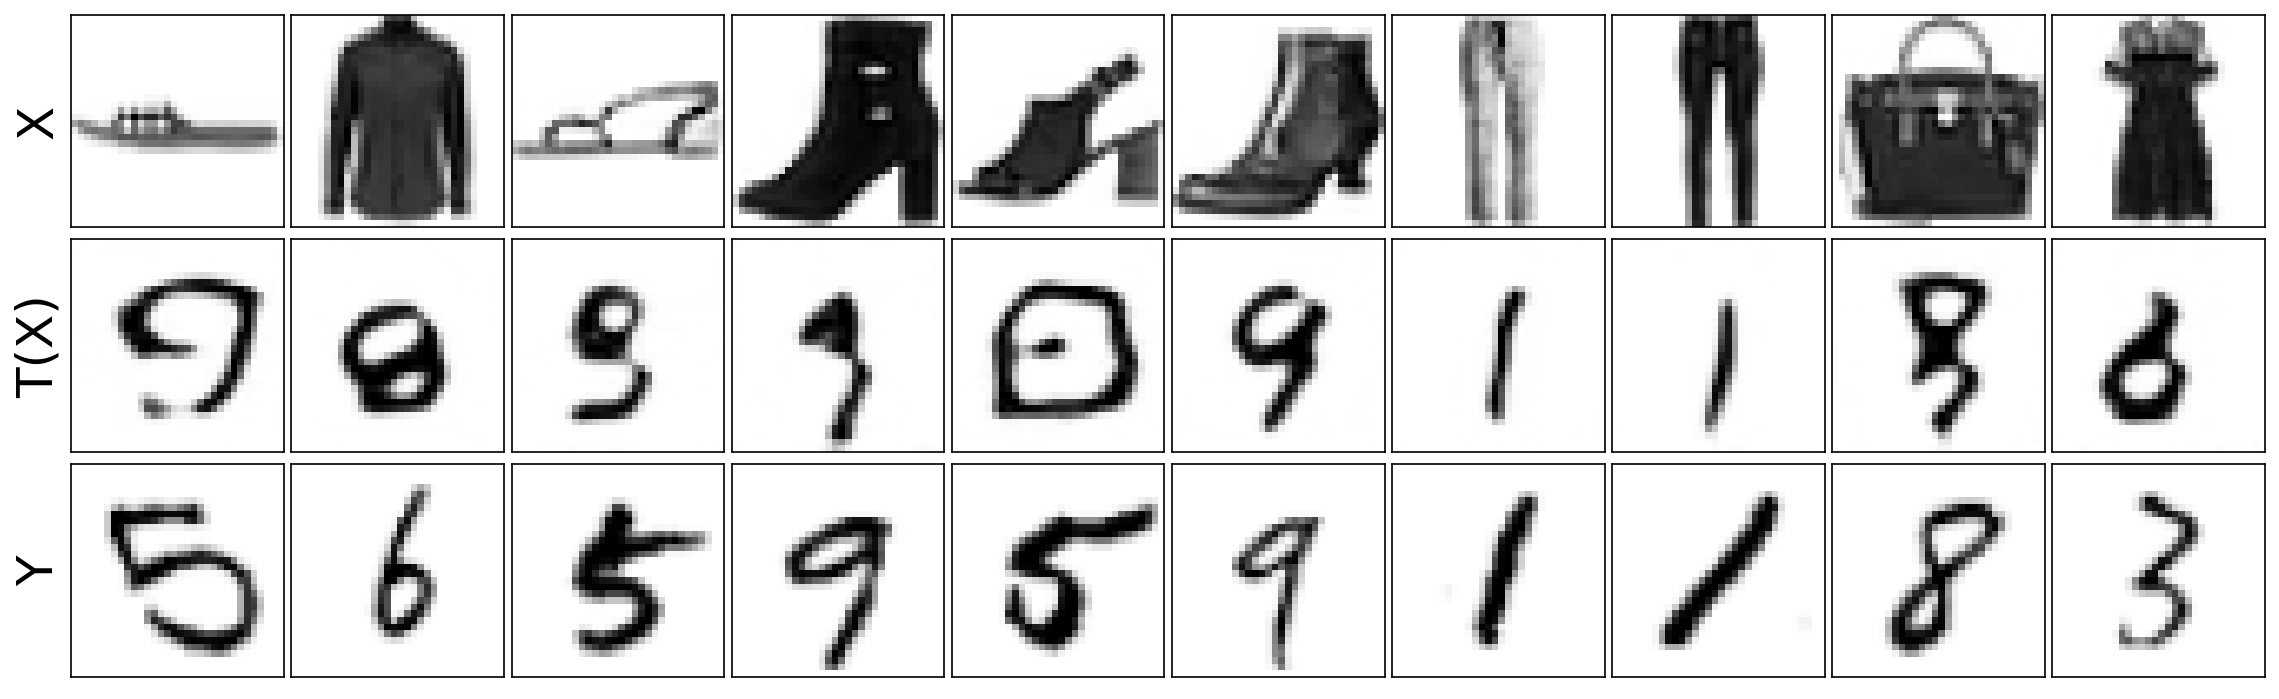

X_random results


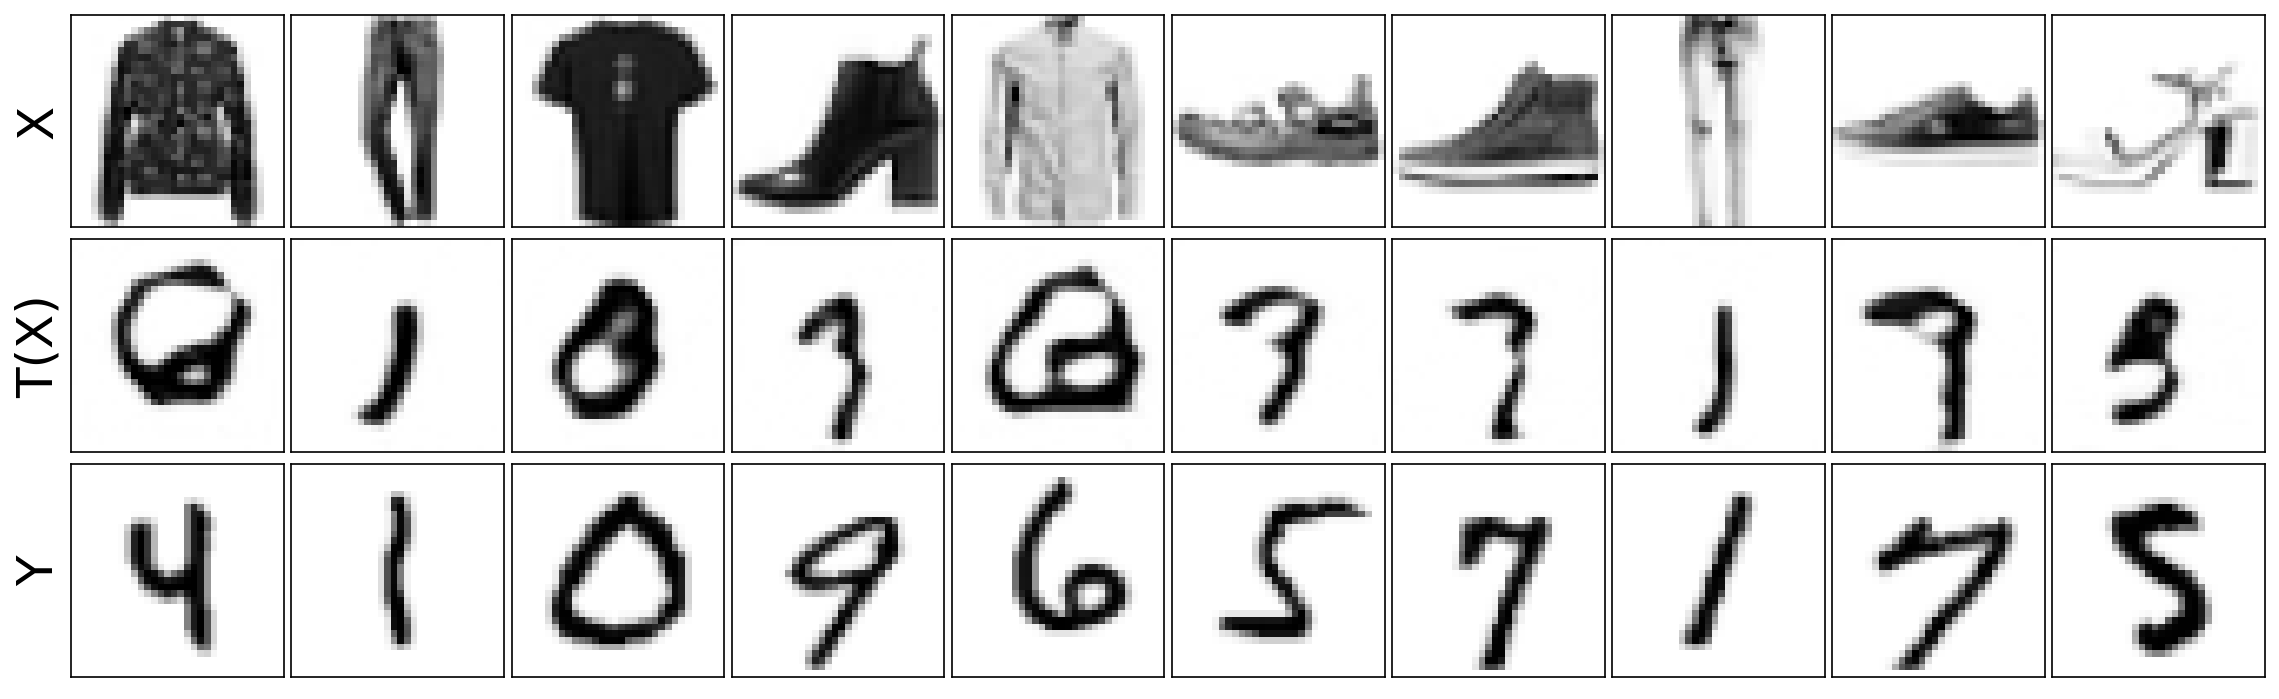

X_fixed results


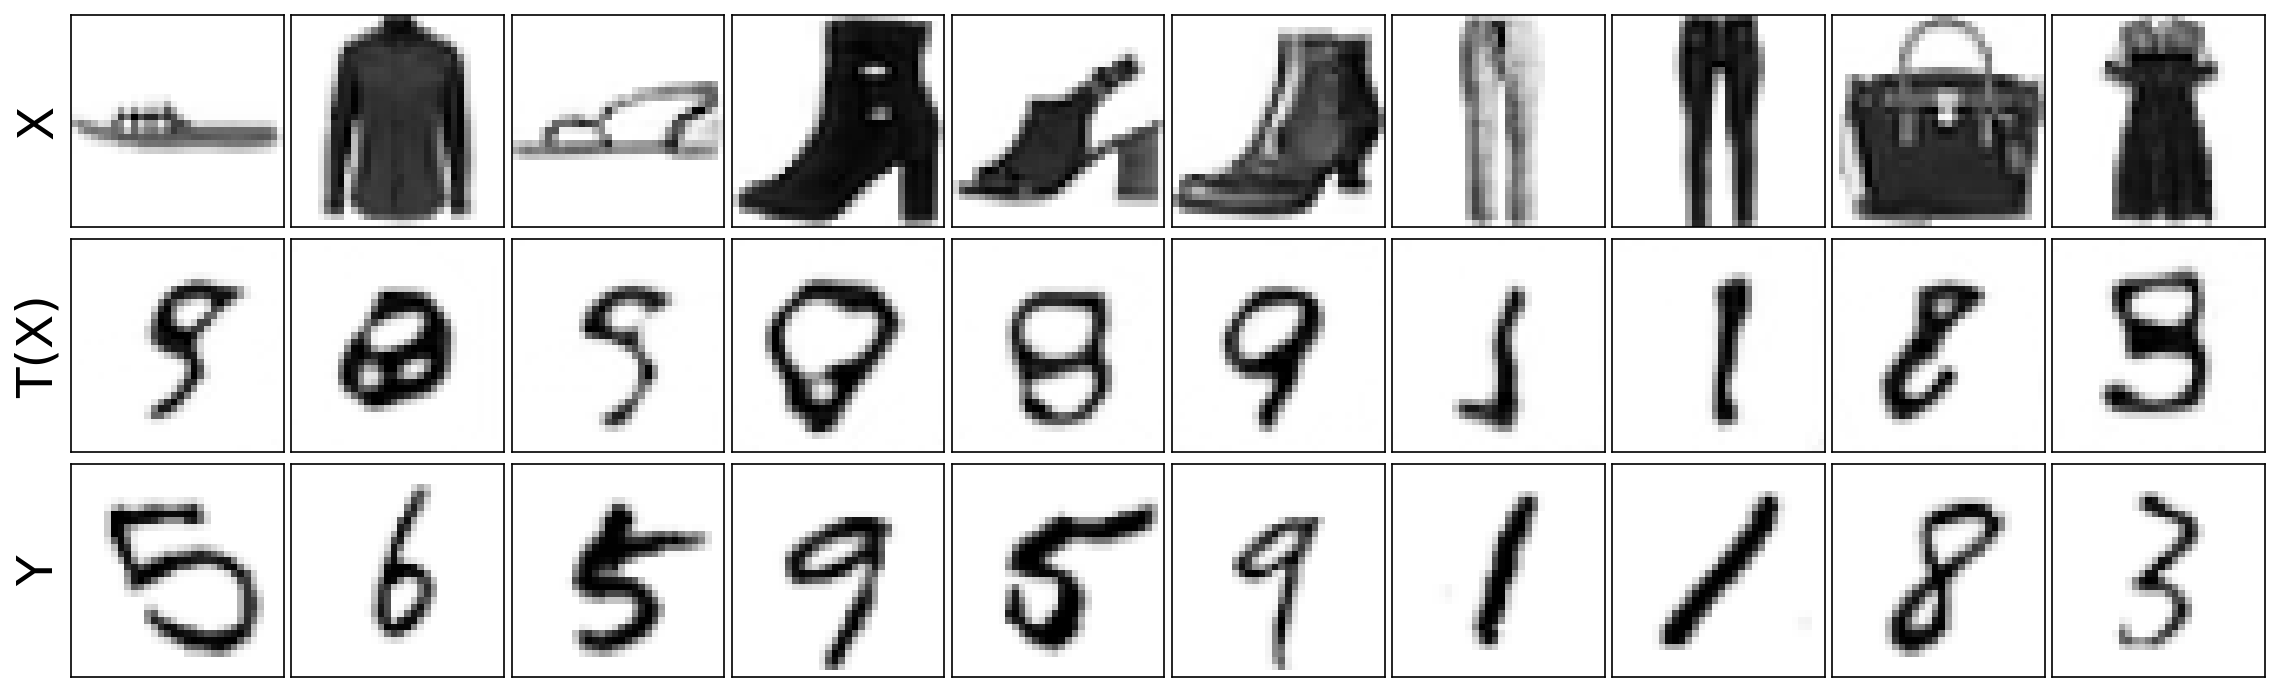

X_random results


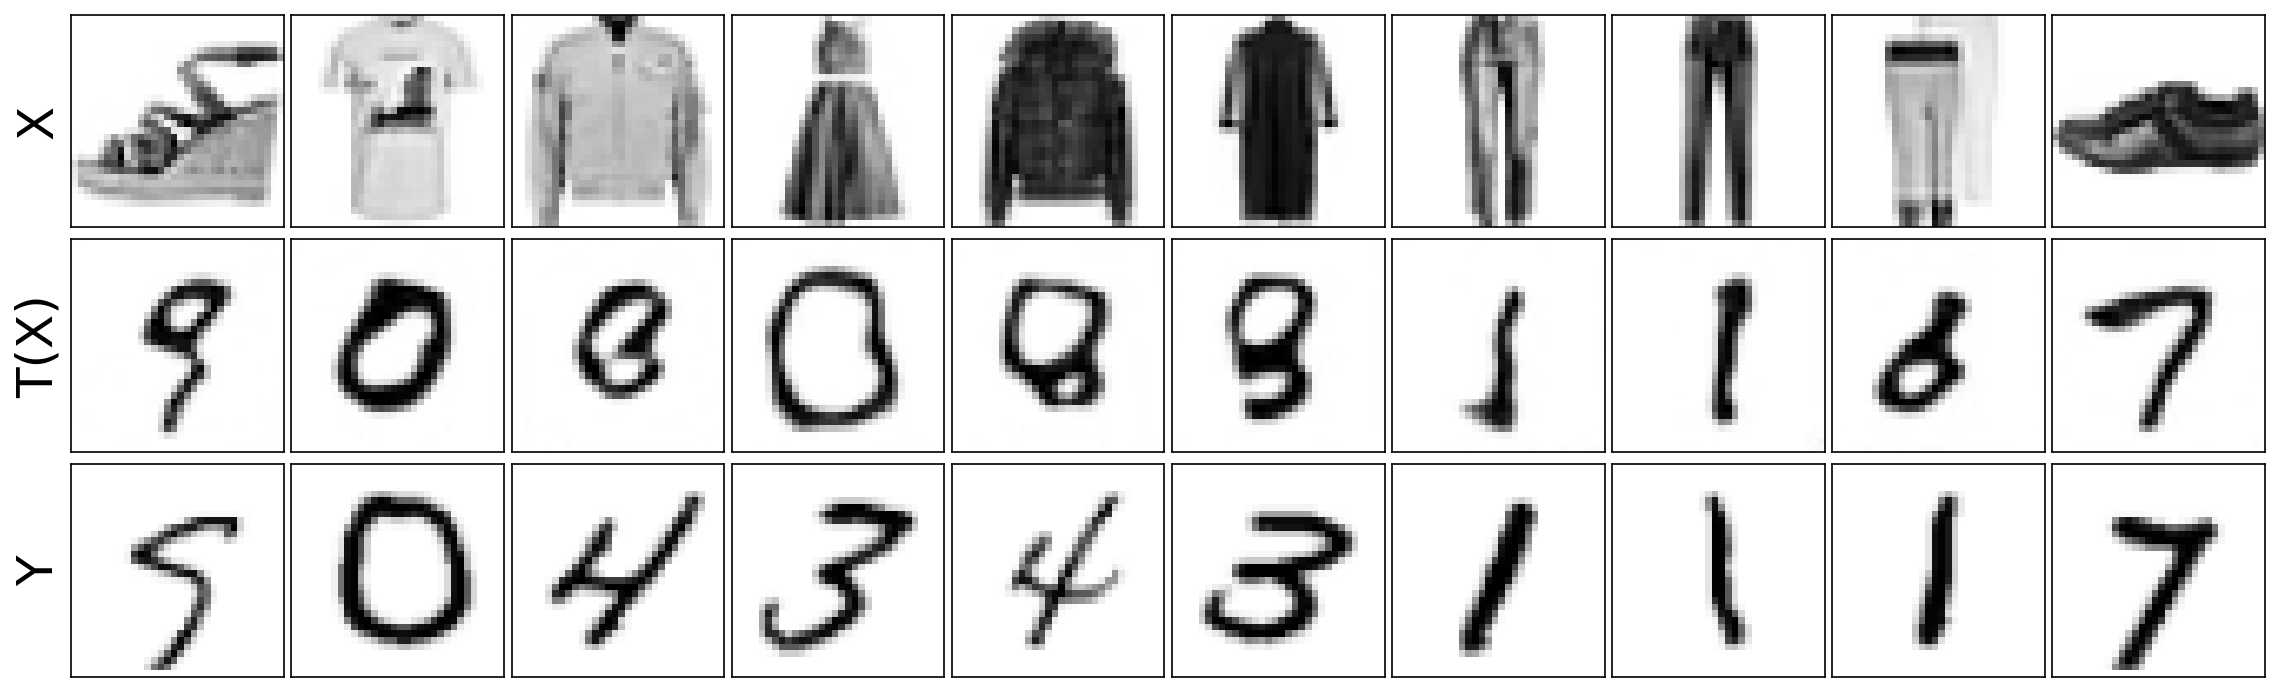

In [6]:
train(T, D, T_opt, D_opt, 
  T_XY_sampler = T_XY_sampler,
  D_XY_sampler = D_XY_sampler,
  T_scheduler = T_scheduler,
  D_scheduler = D_scheduler,
  batch_size = BATCH_SIZE, 
  plot_interval=PLOT_INTERVAL, 
  max_steps=MAX_STEPS)